In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [34]:
plt.style.use('seaborn')

## Define Constants

In [283]:
L = 21 # length of filter
SeqLen = 100_000 # length of test data
SNR = 10
lms_mu = 0.01

nlms_mu = 1.0
delta = 1e-6

beta = .995
reg = 1e-3

## Generate Input Data

Convolve a random sequence by a fixed but random impulse response

In [284]:
h = [
    -0.02010411882885732,
    -0.05842798004352509,
    -0.061178403647821976,
    -0.010939393385338943,
    0.05125096443534972,
    0.033220867678947885,
    -0.05655276971833928,
    -0.08565500737264514,
    0.0633795996605449,
    0.310854403656636,
    0.4344309124179415,
    0.310854403656636,
    0.0633795996605449,
    -0.08565500737264514,
    -0.05655276971833928,
    0.033220867678947885,
    0.05125096443534972,
    -0.010939393385338943,
    -0.061178403647821976,
    -0.05842798004352509,
    -0.02010411882885732,
]

In [285]:
x = np.random.randn(SeqLen)
y = np.convolve(x, h, 'same') + np.random.randn(SeqLen)*1/SNR

Confirm that low pass filter is working

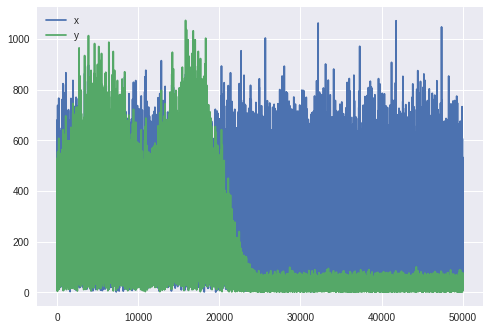

In [286]:
plt.plot(abs(np.fft.rfft(x)), label="x")
plt.plot(abs(np.fft.rfft(y)), label="y")
plt.legend()

# Create and use filter

In [293]:
class LMS:
    """ Least mean squares filter
        Arguments:
            L : length of filter in samples
            mu: learning rate of filter
    """
    def __init__(self, L, mu):
        self.w = np.random.randn(L)
        self.mu = mu
        
    def process(self, X, y):
        yhat = self.w.T@X
        e = y-yhat
        self.w += self.mu * e * X
        mse = e**2
        return mse, yhat

In [294]:
class NLMS:
    """ NLMS filter class
        Arguments:
            L     : length of filter in samples
            mu    : learning rate of filter
            delta : factor to add for numerical stability
            
    """
    def __init__(self, L, mu, delta):
        self.w = np.random.randn(L)
        self.mu = mu
        self.delta = delta
        
    def process(self, X, y):
        yhat = self.w.T@X
        e = y-yhat
        self.w += self.mu * e * X / X.dot(X)
        mse = e**2
        return mse, yhat

![rls_summary](./imgs/rls_summary.png)

$\alpha \to e$  
$g \to K$  

In [295]:
class RLS:
    """ Recursive least squares filter
        Arguments:
            L    : length of filter in samples
            beta : forgetting factor
            reg  : regularization factor
    """
    def __init__(self, L, beta, reg):
        self.w = np.random.randn(L)
        self.beta = beta
        self.reg  = reg
        self.P = 1/reg*np.eye(L,L)
        
    def process(self, X, y):
        yhat = self.w.T@X
        e = y-yhat
        # denominator = beta + X.T * z
        denum = self.beta + (X.T@self.P@X)
        K = (self.P@X)/denum
        self.P = (self.P - (K.dot(X.T@self.P)))/self.beta
        self.w += e*K
        mse = e**2
        return mse, yhat

In [296]:
lms = LMS(L,lms_mu)
nlms = NLMS(L, nlms_mu, delta)
rls = RLS(L, beta, reg)

In [297]:
yhat_lms  = np.zeros(y.shape)
yhat_nlms = np.zeros(y.shape)
yhat_rls  = np.zeros(y.shape)
es_lms    = np.zeros(y.shape)
es_nlms   = np.zeros(y.shape)
es_rls    = np.zeros(y.shape)
for i in range(L, y.shape[0]):
    es_lms[i], yhat_lms[i] = lms.process(x[i-L:i], y[i])
    es_nlms[i], yhat_nlms[i] = nlms.process(x[i-L:i], y[i])
    es_rls[i], yhat_rls[i] = rls.process(x[i-L:i], y[i])

/home/zach/anaconda3_v2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in matmul
/home/zach/anaconda3_v2/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in matmul
/home/zach/anaconda3_v2/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in matmul
/home/zach/anaconda3_v2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in matmul


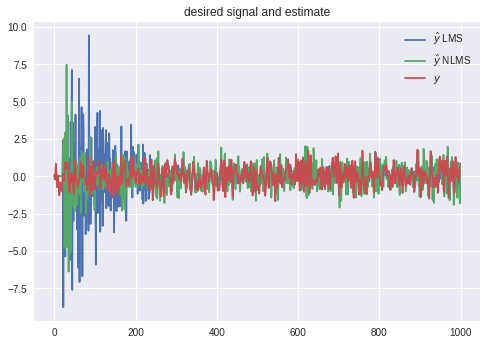

In [299]:
plt.plot(yhat_lms[:1000], label=r"$\hat{y}$ LMS")
plt.plot(yhat_nlms[:1000], label=r"$\hat{y}$ NLMS")
#plt.plot(yhat_rls[:1000], label=r"$\hat{y}$ RLS")
plt.plot(y[:1000], label=r"$y$")
plt.title("desired signal and estimate")
plt.legend()

Text(0.5, 1.0, 'MSE')

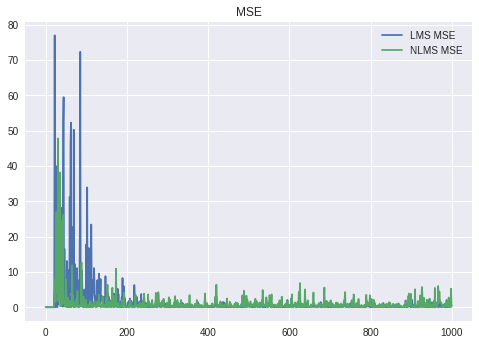

In [303]:
plt.plot(abs(es_lms[:1000]), label="LMS MSE")
plt.plot(abs(es_nlms[:1000]), label="NLMS MSE")
#plt.plot(abs(es_rls[:1000]), label="RLS error")
plt.legend()
plt.title("MSE")

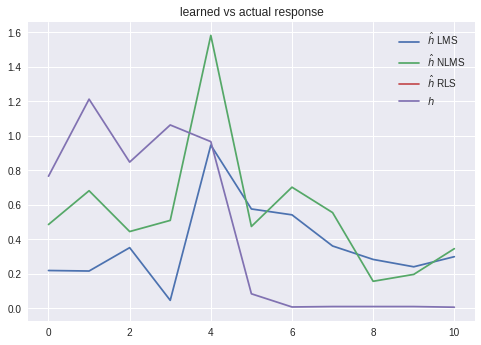

In [304]:
plt.plot(np.abs(np.fft.rfft(lms.w)), label=r"$\hat{h}$ LMS")
plt.plot(np.abs(np.fft.rfft(nlms.w)), label=r"$\hat{h}$ NLMS")
plt.plot(np.abs(np.fft.rfft(rls.w)), label=r"$\hat{h}$ RLS")
plt.plot(np.abs(np.fft.rfft(h)), label=r"$h$")
plt.title("learned vs actual response")
plt.legend()